### Final Regression Informed DAG Generation

The learnings from the best of the DAGS generated with py-tetrad, feature importance from the regression analysis, and Thomas's domain expertise allowed us to create a cogen final DAG using NetworkX, using both Linear and Logistic regression to generate the strength and direction of edges.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression

BASE_DIR = Path().resolve().parent

In [8]:
files_path = BASE_DIR / 'data_main' / "natality_aligned_10pct_sample.csv"

In [9]:
def load_and_preprocess(
    files_path: Path,
    chunk_size: int = 100_000,
    sample_frac: float = 1.0
):
    """
    Loads natality data, samples, creates composite RF/IP variables,
    applies improved cleaning, retains all columns, and ensures numerical encoding.
    """
    first_cols = pd.read_csv(files_path, nrows=0).columns

    ld_cols = [c for c in first_cols if c.lower().startswith("ld_")]
    rf_cols = [c for c in first_cols if c.lower().startswith("rf_")]
    ip_cols = [c for c in first_cols if c.lower().startswith("ip_")]

    usecols = [
        "bmi", "meduc", "feduc", "precare", "previs", "cig_rec",
        "morbidity_reported", "bfacil", "pay", "attend", "me_pres", "me_rout",
        "mager", "fagecomb", "mrace6", "mracehisp", "frace6", "fracehisp",
        "priordead", "priorlive", "priorterm",
        "date"
    ] + ld_cols + rf_cols + ip_cols

    rename_map = {
        "bmi": "Body Mass Index",
        "meduc": "Mother Education",
        "feduc": "Father Education",
        "mrace6": "Mother Race",
        "mracehisp": "Mother Hispanic",
        "frace6": "Father Race",
        "fracehisp": "Father Hispanic",
        "mager": "Mother Age",
        "fagecomb": "Father Age",
        "priordead": "Prior Pregnancy Deaths",
        "priorlive": "Prior Pregnancy Live Births",
        "priorterm": "Prior Pregnancy Termination",
        "precare": "Pre-natal Care Begins",
        "previs": "Pre-natal Visits",
        "cig_rec": "Cigarette Smoking",
        "morbidity_reported": "Maternal Morbidity",
        "bfacil": "Facility",
        "pay": "Payment Method",
        "attend": "Medical Provider",
        "ld_chor": "Chorioamnionitis Present",
        "me_pres": "Fetal Presentation at Delivery",
        "me_rout": "Final Route of Delivery",
        "date": "Date of Birth",
    }

    dfs = []
    reader = pd.read_csv(files_path, chunksize=chunk_size, usecols=usecols, low_memory=False)

    for chunk in reader:
        sampled = chunk.sample(frac=sample_frac, random_state=123)

        # Convert RF/IP to numeric
        rf_present = [c for c in rf_cols if c in sampled.columns]
        ip_present = [c for c in ip_cols if c in sampled.columns]

        for cols in [rf_present, ip_present]:
            if cols:
                sampled[cols] = sampled[cols].apply(pd.to_numeric, errors="coerce").fillna(0)

        # Composite indicators
        sampled["Risk Factor Present"] = (sampled[rf_present].sum(axis=1) > 0).astype(int)
        sampled["Infection Present"] = (sampled[ip_present].sum(axis=1) > 0).astype(int)

        sampled.drop(columns=rf_present + ip_present, inplace=True)
        sampled.rename(columns=rename_map, inplace=True)

        dfs.append(sampled)

    df = pd.concat(dfs, ignore_index=True)

    # Convert date to numeric ordinal
    if "Date of Birth" in df.columns:
        df["Date of Birth"] = pd.to_datetime(df["Date of Birth"], errors="coerce").map(lambda x: x.toordinal() if pd.notna(x) else np.nan)

    # Basic numeric cleaning
    df = df.dropna()
    df["Maternal Morbidity"] = df["Maternal Morbidity"].astype(int)

    return df


df = load_and_preprocess(files_path, sample_frac=0.1)

In [ ]:
def build_dag1():
    G = nx.DiGraph()

    tiers = {
        "Demographics": [
            "Mother Race", "Father Race", "Mother Age", "Father Age",
            "Mother Education", "Father Education",
        ],
        "Pre-Pregnancy": [
            "Prior Pregnancy Live Births", "Body Mass Index",
        ],
        "Pregnancy": [
            "Pre-natal Visits", "Risk Factor Present", "Infection Present",
        ],
        "Delivery": [
            "Final Route of Delivery", "Fetal Presentation at Delivery",
        ],
        "Outcome": ["Maternal Morbidity"]
    }

    # Add nodes
    for group in tiers.values():
        G.add_nodes_from(group)

    # Edges (same as before)
    edges = [
        ("Mother Education", "Prior Pregnancy Live Births"),
        ("Mother Race", "Prior Pregnancy Live Births"),
        ("Mother Age", "Prior Pregnancy Live Births"),

        ("Mother Education", "Body Mass Index"),
        ("Mother Race", "Body Mass Index"),
        ("Mother Age", "Body Mass Index"),

        ("Mother Education", "Pre-natal Visits"),
        ("Father Education", "Pre-natal Visits"),
        ("Mother Race", "Pre-natal Visits"),
        ("Father Race", "Pre-natal Visits"),
        ("Mother Age", "Pre-natal Visits"),
        ("Father Age", "Pre-natal Visits"),

        ("Body Mass Index", "Pre-natal Visits"),
        ("Body Mass Index", "Risk Factor Present"),
        ("Body Mass Index", "Infection Present"),
        ("Body Mass Index", "Maternal Morbidity"),

        ("Pre-natal Visits", "Maternal Morbidity"),
        ("Pre-natal Visits", "Risk Factor Present"),
        ("Pre-natal Visits", "Infection Present"),
        ("Pre-natal Visits", "Fetal Presentation at Delivery"),

        ("Fetal Presentation at Delivery", "Maternal Morbidity"),
        ("Final Route of Delivery", "Maternal Morbidity"),
        ("Risk Factor Present", "Maternal Morbidity"),
        ("Infection Present", "Maternal Morbidity"),
    ]

    G.add_edges_from(edges)
    return G, tiers

In [ ]:
def is_binary(series):
    return set(series.unique()) <= {0, 1}

def compute_standardized_coef(X, y, logistic=False):
    """
    Returns standardized β coefficient.
    """
    x_std = (X - X.mean()) / X.std()
    y_std = (y - y.mean()) / y.std() if not logistic else y

    if logistic:
        model = LogisticRegression(max_iter=200).fit(x_std.values.reshape(-1,1), y)
        coef = float(model.coef_[0])
    else:
        model = LinearRegression().fit(x_std.values.reshape(-1,1), y_std)
        coef = float(model.coef_[0])

    return abs(coef)


def compute_edge_strengths(G, df):
    for u, v in G.edges():
        try:
            X = df[u]
            y = df[v]

            if is_binary(y):  # logistic for binary outcomes
                weight = compute_standardized_coef(X, y, logistic=True)
            else:
                weight = compute_standardized_coef(X, y, logistic=False)

            G[u][v]["weight"] = weight
        except Exception as e:
            print(f"Warning: Could not compute weight for {u} → {v}: {e}")
            G[u][v]["weight"] = 0.0001  # avoid invisible edges

In [ ]:
def plot_weighted_dag(G, tiers):
    try:
        pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
    except:
        pos = nx.spring_layout(G, k=2.0, seed=42)

    palette = ["#fde68a", "#bbf7d0", "#bfdbfe", "#e9d5ff", "#fecaca"]
    tier_colors = {node: color
                   for color, (_, nodes) in zip(palette, tiers.items())
                   for node in nodes}

    weights = np.array([G[u][v].get("weight", 0.1) for u, v in G.edges()])
    widths = 1 + 8 * (weights / weights.max())

    plt.figure(figsize=(20, 14))
    nx.draw(
        G, pos,
        with_labels=True,
        node_color=[tier_colors[n] for n in G.nodes()],
        node_size=3200,
        width=widths,
        edge_color=weights,
        edge_cmap=plt.cm.magma,
        arrowsize=18,
        font_size=16,
    )

    edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title("Tiered & Weighted Causal DAG with Standardized Edge Strengths for Top Morbidity Predictors", fontsize=20)
    plt.show()

/tmp/ipython-input-3924115516.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  coef = float(model.coef_[0])
/tmp/ipython-input-3924115516.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  coef = float(model.coef_[0])
/tmp/ipython-input-3924115516.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  coef = float(model.coef_[0])
/tmp/ipython-input-3924115516.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will err

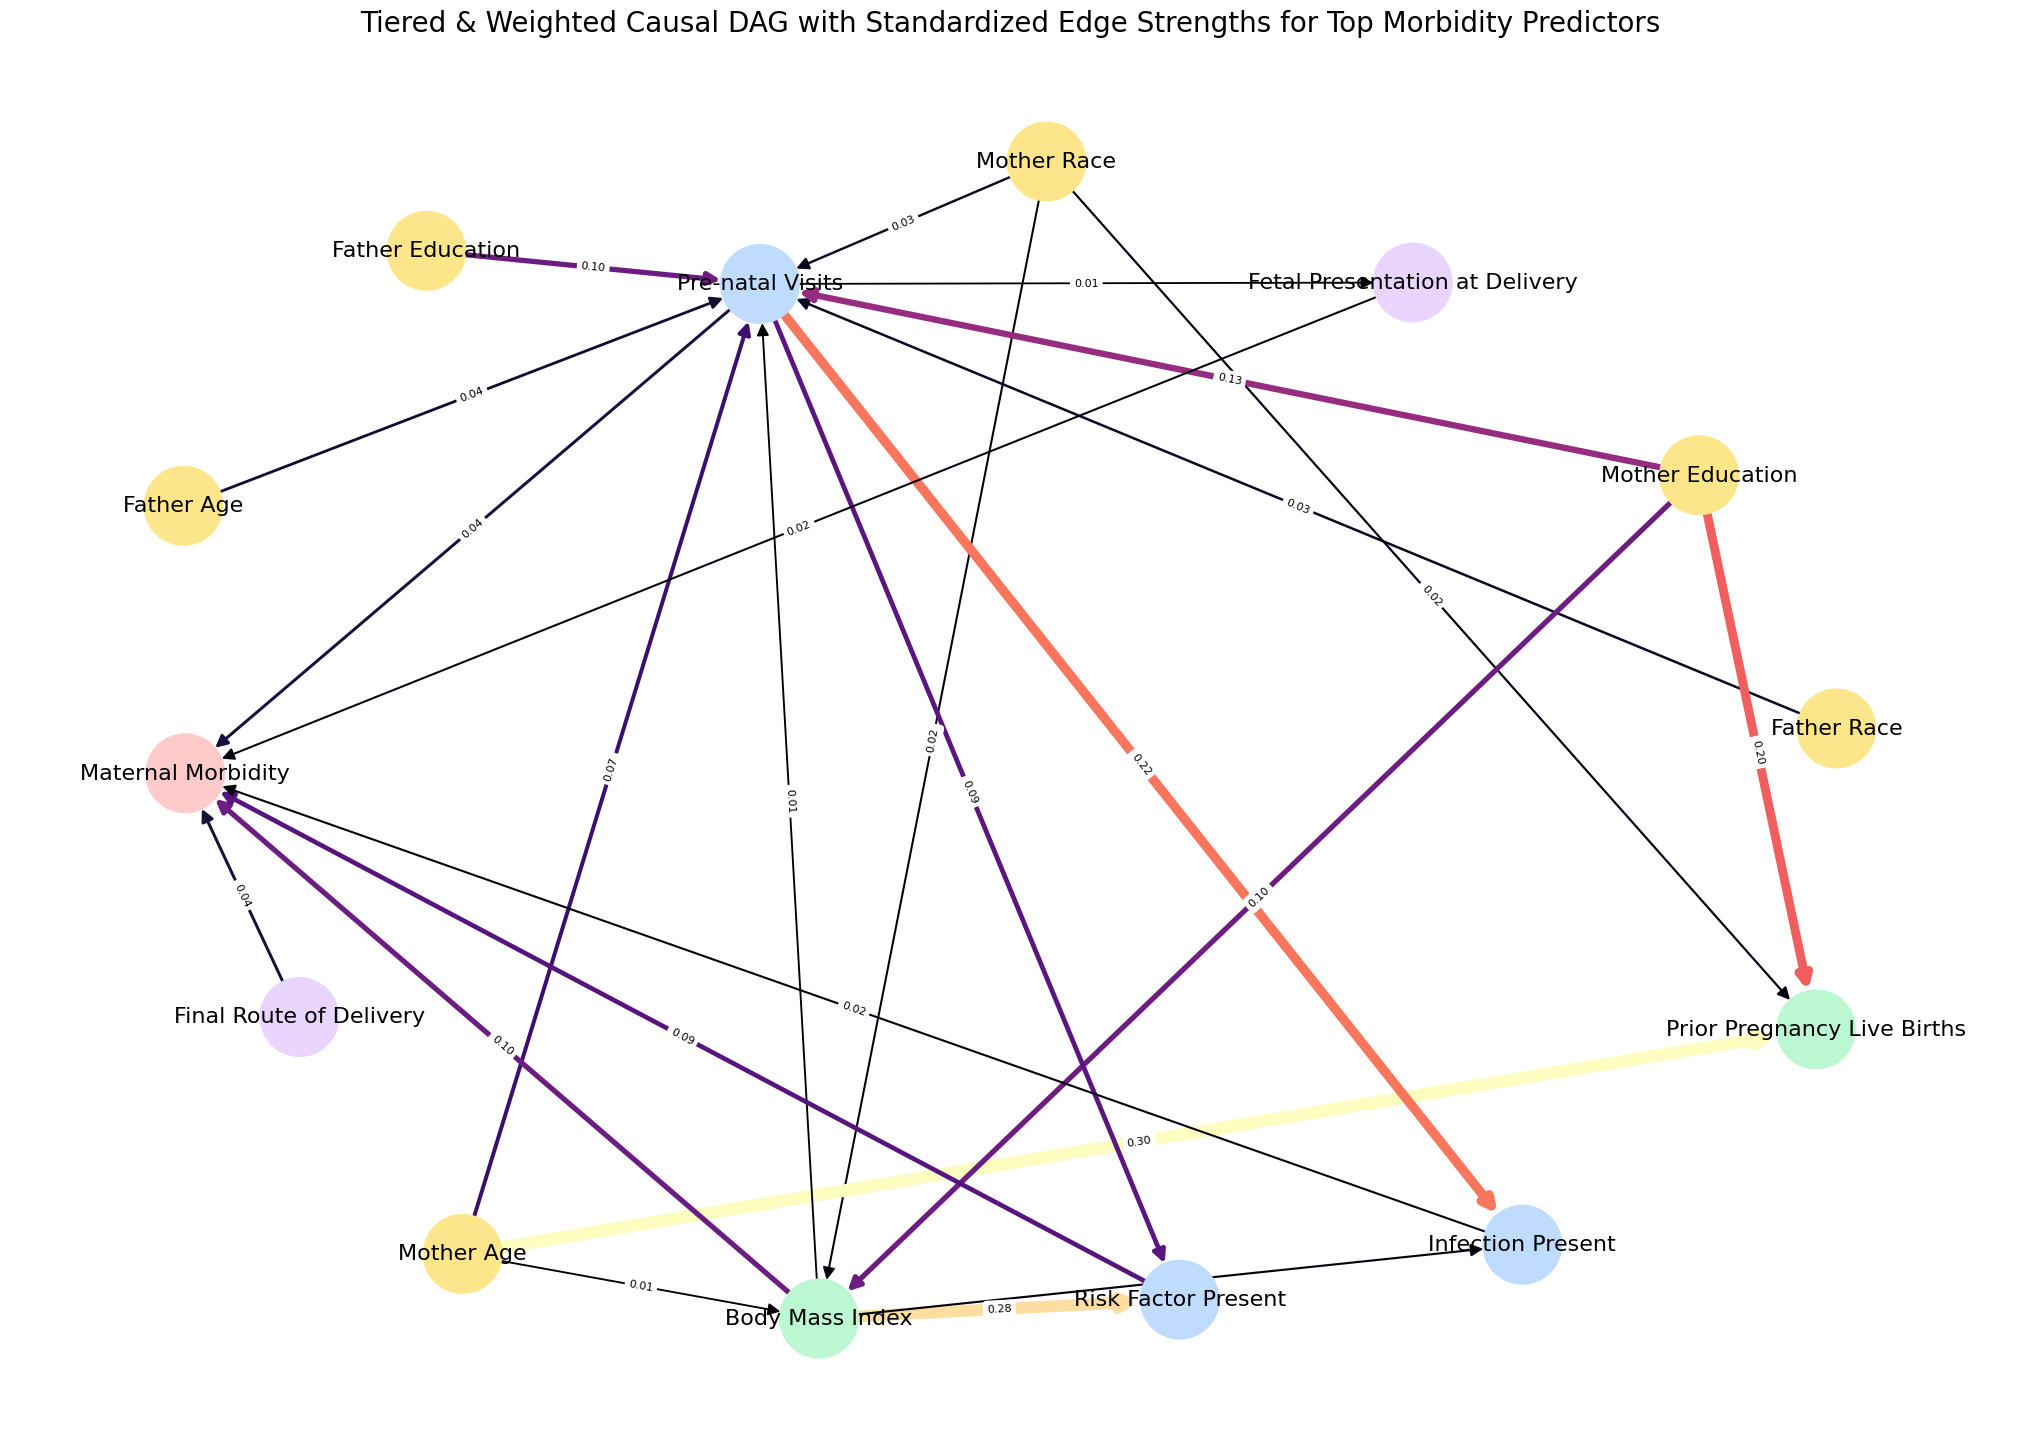

In [ ]:
G, tiers = build_dag1()
compute_edge_strengths(G, df)
plot_weighted_dag(G, tiers)